In [2]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling
from qumcmc.prob_dist import kl_divergence, js_divergence

from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines_qulacs import *     #for Qulacs Simulator backend
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from typing import Union
from qumcmc.trajectory_processing import *
import seaborn as sns

#
import random

In [3]:

def js_divergence(dict_p:dict,dict_q:dict, prelim_check=True):
    ''' 
    Returns JS divergence JS(p||q);
    
    Args:
    dict_p: distribution p ({random_variable: prob}),

    dict_q: distribution q ({random_variable: prob}),

    prelim_check: default 'True'. 
    If user is completely sure that 
    dict_p and dict_q have same keys and that both the distributionss are
    normalised then user can set it to 'False'.
    '''
    if prelim_check:
        #check for whether or not dict_p and dict_q have same keys
        keys_p,keys_q=list(dict_p.keys()),list(dict_q.keys())
        keys_p.sort();keys_q.sort()
        if keys_p==keys_q: pass  #"keys of both the dictionaries dont match!"
        else :
            for key in set(dict_p.keys()).union(set(dict_q.keys())) :
                if key not in dict_p.keys(): dict_p[key] = 0.0
                if key not in dict_q.keys(): dict_q[key] = 0.0

        # print('p: ', dict_p)
        # print('q: ', dict_q)
        # check for whether values add to 1.
        eps=1e-6
        sum_vals_p=np.sum(list(dict_p.values()))
        assert np.abs(sum_vals_p-1.0)<=eps, "sum of values of dict_p must be 1."
        sum_vals_q=np.sum(list(dict_q.values()))
        assert np.abs(sum_vals_q-1.0)<=eps, "sum of values of dict_q must be 1."

    #prep for caln
    p=DiscreteProbabilityDistribution(dict_p).index_sorted_dict()
    q=DiscreteProbabilityDistribution(dict_q).index_sorted_dict()
    p_arr,q_arr=np.array(list(p.values())).reshape((len(p))), np.array(list(q.values())).reshape((len(q)))
    val_m = np.round(0.5 * (p_arr + q_arr),decimals=8)
    #print("val_m:");print(val_m)
    m=dict(zip(list(p.keys()),val_m))
    
    # print('m: ', m)
    
    #print("m:");print(m)
    return 0.5 * (kl_divergence(p, m, prelim_check=False) +  kl_divergence(q, m, prelim_check=False ))


In [4]:
a = {'1':1.0}; b = {'1': 0.0, '0':1.0}

kl_divergence(a,b), js_divergence(a,b)

/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:151: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:151: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:151: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))


(inf, 1.0)

            MODEL : my_model
Non-zero Interactions (J) : 28 / 28
Non-zero Bias (h) : 8 / 8
---------------------------------------------
Average Interaction Strength <|J|> :  0.46081249999999996
Average Bias Strength <|h|>:  0.3175
alpha :  0.7625841344570155
---------------------------------------------


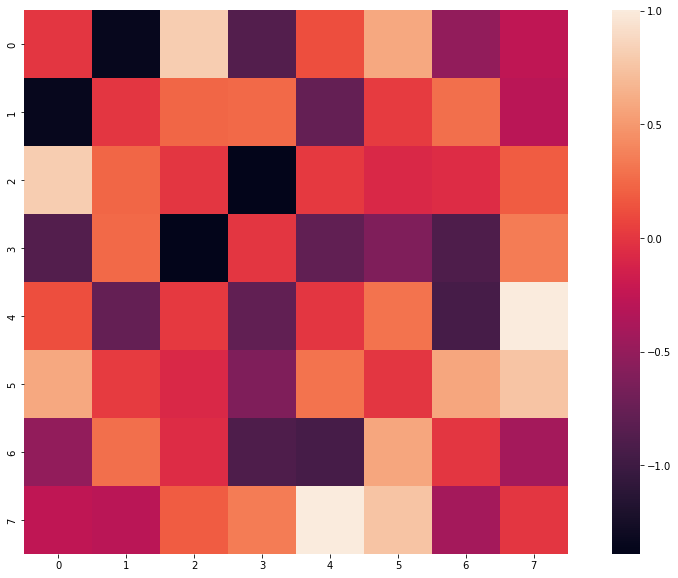

In [5]:
# define the model
np.random.seed(2) ##l lucky-seed: 610358
n_spins = 8

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')

model.model_summary()
## set current beta
beta = 2.5

## run exact sampling over all possible configurations 
esm = Exact_Sampling(model, beta)
# esm.run_exact_sampling(beta)

     MODEL : my_model |  beta : 2.5
Num Most Probable States : 7
Entropy : 2.3572969242675743
---------------------------------------------


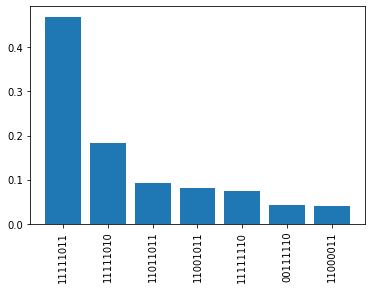

In [6]:
esm.sampling_summary()

#### HELPER FUNCTIONS

In [7]:
int_to_binary = lambda state_obtained, n_spins : f"{state_obtained:0{n_spins}b}"
binary_to_bipolar = lambda string : 2.0 * float(string) - 1.0

def get_observable_expectation(observable: callable, mcmc_chain: MCMCChain, skip_init:int= 100) :

    sample_observable = []
    for s in mcmc_chain.accepted_states :

        sample_observable.append(observable(s) )
    
    sample_observable = np.array(sample_observable)
        
    return sample_observable.mean(dtype= float)#, sample_observable.var(dtype= float)


def correlation_spins(state: str, indices : Union[tuple, List] ):

    assert len(indices) <= len(state)
    
    
    prod = 1.0
    for j in indices :
        prod *= binary_to_bipolar(state[j])

    return prod

def cd_J(index, data_distribution:DiscreteProbabilityDistribution, mcmc_chain: MCMCChain):

    assert len(index) == 2
    observable = lambda s: correlation_spins(s, [index[0], index[1]])
    r = data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

    return r

def cd_h(index:int, data_distribution:DiscreteProbabilityDistribution, mcmc_chain: MCMCChain):

    assert isinstance(index, int)
    observable = lambda s: correlation_spins(s, [index])
    r = data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

    return r

#### Class for Training

In [8]:
from copy import deepcopy
# @dataclass
class cd_training():
    ''' 
    model: initial model = (J init, h init) at some temp T
    beta: 1/Temperature
    data_dist: empirical data which we want to learn!
    
    '''

    def __init__(self, model: IsingEnergyFunction, beta:float ,data_dist: DiscreteProbabilityDistribution) -> None:
        self.model = deepcopy(model)
        self.model_beta = beta
        self.data_distribution = data_dist
        self.training_history = {}
        self.list_pair_of_indices=[[i,j] for i in range(1,self.model.num_spins) for j in range(i,self.model.num_spins) if j!=i]
        

    def cd_J(self, index, mcmc_chain: MCMCChain):

        assert len(index) == 2
        observable = lambda s: correlation_spins(s, [index[0], index[1]])
        r = self.data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

        return r

    def cd_h(self, index:int, mcmc_chain: MCMCChain):

        assert isinstance(index, int)
        observable = lambda s: correlation_spins(s, [index])
        r = self.data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

        return r

    # @setattr
    # def data_distribution()
    
    def _train_on_mcmc_chain(self, lr:float= 0.01, 
    method = 'quantum-enhanced', 
    iterations: int = 100, # rename this iterations to something else
    num_random_Jij: int=10,
    mcmc_steps:int =1000 ):# we will try to increase mcmc steps. 

        if method == 'quantum-enhanced' :
            self.mcmc_chain = quantum_enhanced_mcmc(
            n_hops=mcmc_steps,
            model=self.model,
            temperature=1/self.model_beta,
            verbose= False
            )
        elif method == 'classical-uniform' : 
            self.mcmc_chain = classical_mcmc(
            n_hops=mcmc_steps,
            model=self.model,
            temperature=1/self.model_beta,
            verbose= False
            )
        
        ## random update strategy ##
        ## just realised that even this is not a good thing! 
        assert iterations<=self.model.num_spins, f"iterations should be <= num_spins (which is= {self.model.num_spins}) "
        assert num_random_Jij<=len(self.list_pair_of_indices), f"num_random_Jij should be <=len(self.list_pair_of_indices) (which is= {len(self.list_pair_of_indices)})"
        
        list_random_indices=random.sample(range(0,self.model.num_spins), iterations)
        #list_pair_of_indices=[[i,j] for i in range(1,self.model.num_spins) for j in range(i,self.model.num_spins) if j!=i]
        #list_pair_of_different_indices=random.sample(self.list_pair_of_indices,k=num_random_Jij)

        list_pair_of_different_indices=[[list_random_indices[j],
                    random.choice(list(range(0,list_random_indices[j]))+list(range(list_random_indices[j]+1,self.model.num_spins)))] 
                    for j in range(0,iterations)]
        
        # ## Update J
        for k in range(len(list_pair_of_different_indices)):
            indices_J=list_pair_of_different_indices[k]
            updated_param_j=model.J[indices_J[0],indices_J[1]] - lr * self.cd_J(indices_J, self.mcmc_chain)
            self.model._update_J(updated_param_j, indices_J)

        for k in range(iterations):
            #indices_J=list_pair_of_different_indices[k]
            #updated_param_j = model.J[indices_J[0],indices_J[1]] - lr * self.cd_J(indices_J, self.mcmc_chain)

            # update h
            index_h=list_random_indices[k]
            updated_param_h=model.h[index_h] - lr*self.cd_h(index_h,self.mcmc_chain)

            #self.model._update_J(updated_param_j, indices_J)
            self.model._update_h(updated_param_h, index_h)

            
    def train(self, lr:float= 0.01, method = 'quantum-enhanced', 
    epochs:int = 10, schedule:str= 'linear', num_random_Jij:int=5,
    show_kldiv:bool = True ):

        ## random update strategy ##
        kl_div = []; js_div= []
        iterator = tqdm(range(epochs), desc= 'training epochs')
        iterator.set_postfix({'method': method})

        if schedule == 'linear': 
            mcmc_steps = np.linspace(100, 5000, epochs, dtype= int)
            # params = self.model.num_spins * (self.model.num_spins + 1) / 2
            iterations = np.linspace(int(self.model.num_spins/4), self.model.num_spins, epochs, dtype= int)
            lr_c = np.linspace(lr, 10 * lr, epochs, dtype= float )

        for epoch in iterator:

            self._train_on_mcmc_chain(lr= lr_c[epoch] , 
            method = method, iterations= iterations[epoch], num_random_Jij=num_random_Jij,
            mcmc_steps= mcmc_steps[epoch] )

            if show_kldiv:

                
                kl_div.append(kl_divergence(  self.data_distribution,self.mcmc_chain.get_accepted_dict(normalize= True)  ))
                js_div.append(js_divergence(  self.data_distribution,self.mcmc_chain.get_accepted_dict(normalize= True)  ))
                iterator.set_postfix( { 'method ': method, 'js div ' : js_div[-1], 'mcmc-steps ': mcmc_steps[epoch] })
                # iterator.se
        
        if show_kldiv :
             self.training_history['kl_div']= kl_div
             self.training_history['js_div']= js_div


#### TRIALS

     MODEL : param_model |  beta : 1.0
Num Most Probable States : 4
Entropy : 2.016575422384969
---------------------------------------------


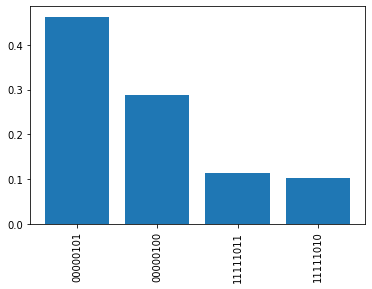

In [9]:
## INITIALISE ANOTHER RANDOM MODEL ##

np.random.seed(1)# should always be in the same cell!  
n_spins = 8

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -3, high= 3, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.4 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
beta_train = 1.0

param_model = IsingEnergyFunction(J, h, name= 'param_model')
param_model_esm = Exact_Sampling(param_model, beta= beta_train)

param_model_esm.sampling_summary()

     MODEL : my_model |  beta : 2.5
Num Most Probable States : 7
Entropy : 2.3572969242675743
---------------------------------------------


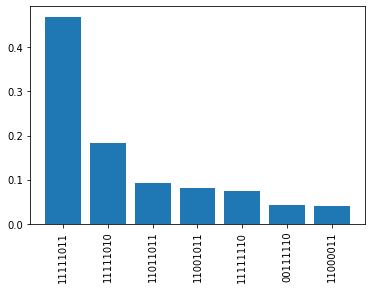

In [10]:
## COMPARE WITH THE DATA-DISTRIBUTION ##
esm.sampling_summary()

#### TRAINING

In [12]:
training_quantum = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_quantum.train(lr = 0.01 ,method = 'quantum-enhanced' , 
epochs= 20, num_random_Jij=param_model.num_spins ,
show_kldiv= True)# when i in hi and i in Jij are same

training epochs: 100%|██████████| 20/20 [08:27<00:00, 25.39s/it, method =quantum-enhanced, js div =0.191, mcmc-steps =5000]


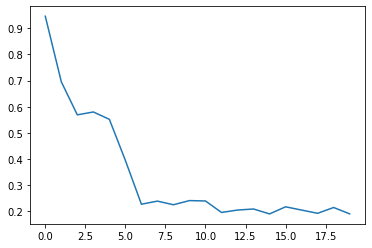

In [13]:
plt.plot(training_quantum.training_history['js_div'])

In [14]:
training_classical = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_classical.train(lr = 0.01 ,method = 'classical-uniform' , 
epochs= 20, num_random_Jij=param_model.num_spins ,
show_kldiv= True)# 

training epochs: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s, method =classical-uniform, js div =0.411, mcmc-steps =5000]


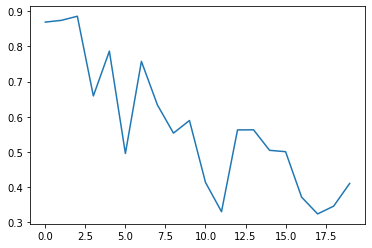

In [15]:
plt.plot(training_classical.training_history['js_div'])

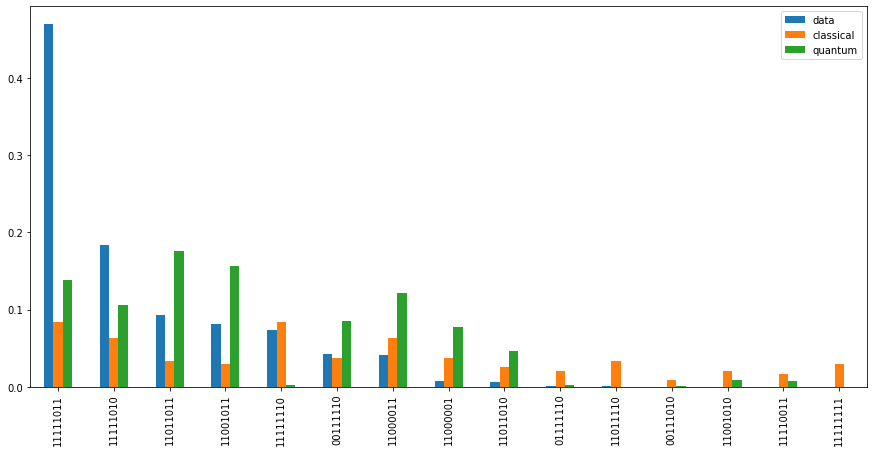

In [17]:
# classical reconstructed model
cl_mcmc_chain_after_train=classical_mcmc(n_hops=5000,model=training_classical.model, temperature=1,verbose=False)
cl_reconstructed_distn=cl_mcmc_chain_after_train.get_accepted_dict(normalize=True)
#print(cl_reconstructed_distn)
# quantum reconstructed model
q_mcmc_chain_after_train=quantum_enhanced_mcmc(n_hops=5000, model=training_quantum.model,temperature=1,verbose=False)
q_reconstructed_distn=q_mcmc_chain_after_train.get_accepted_dict(normalize=True)
#print(q_reconstructed_distn)

plot_multiple_bargraphs([esm.boltzmann_pd, cl_reconstructed_distn, q_reconstructed_distn],
 ['data','classical', 'quantum'], list_normalise=[False,False,False], plot_first_few= 15)

In [13]:
training_quantum = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_quantum.train(lr = 0.05 ,method = 'quantum-enhanced' , 
epochs= 40, iterations= num_spins_prob,num_random_Jij=num_spins_prob ,
mcmc_steps= 1000 , show_kldiv= True)#when i in all hi and Jij which were tweaked is same!

training epochs: 100%|██████████| 40/40 [04:04<00:00,  6.12s/it, method =quantum-enhanced, kl div =0.606]


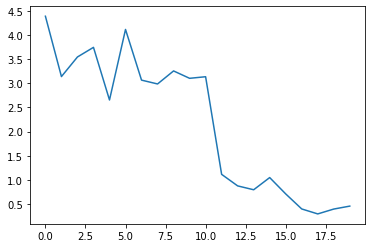

In [55]:
plt.plot(training_quantum.training_history['kl_div'])

In [15]:
training_quantum_11 = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_quantum_11.train(lr = 0.05 ,method = 'quantum-enhanced' , 
epochs= 60, iterations= num_spins_prob,num_random_Jij=num_spins_prob ,
mcmc_steps= 1000 , show_kldiv= True)#when i in all hi and Jij which were tweaked is same!

training epochs: 100%|██████████| 60/60 [06:23<00:00,  6.39s/it, method =quantum-enhanced, kl div =0.538]


In [16]:
training_quantum2 = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_quantum2.train(lr = 0.05 ,method = 'quantum-enhanced' , 
epochs= 40, iterations= num_spins_prob,num_random_Jij=num_spins_prob ,
mcmc_steps= 1000 , show_kldiv= True)# when i in all hi and Jij which were tweaked may or may not be the same!

training epochs: 100%|██████████| 40/40 [04:05<00:00,  6.15s/it, method =quantum-enhanced, kl div =0.234]


In [17]:
training_quantum3 = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_quantum3.train(lr = 0.05 ,method = 'quantum-enhanced' , 
epochs= 40, iterations= num_spins_prob,num_random_Jij=num_spins_prob*2 ,
mcmc_steps= 1000 , show_kldiv= True)# when i in hi and Jij will be be the same!

training epochs: 100%|██████████| 40/40 [04:05<00:00,  6.14s/it, method =quantum-enhanced, kl div =0.546]


In [18]:
param_model.get_J 

array([[ 0.   ,  0.351, -1.748,  0.536,  0.314,  0.244, -1.578, -0.241],
       [ 0.351,  0.   , -0.066,  1.739, -0.787,  1.879, -2.528, -0.548],
       [-1.748, -0.066,  0.   , -2.151,  1.478,  0.746, -2.002,  0.845],
       [ 0.536,  1.739, -2.151,  0.   , -1.544,  2.002, -0.668,  0.363],
       [ 0.314, -0.787,  1.478, -1.544,  0.   , -0.186, -2.31 , -0.443],
       [ 0.244,  1.879,  0.746,  2.002, -0.186,  0.   ,  0.522, -0.877],
       [-1.578, -2.528, -2.002, -0.668, -2.31 ,  0.522,  0.   , -0.757],
       [-0.241, -0.548,  0.845,  0.363, -0.443, -0.877, -0.757,  0.   ]])

In [19]:
training_cl = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_cl.train(lr = 0.05 ,method = 'classical-uniform' , epochs= 50, iterations= num_spins_prob, num_random_Jij=5, mcmc_steps= 1500 , show_kldiv= True)

training epochs: 100%|██████████| 50/50 [00:03<00:00, 12.80it/s, method =classical-uniform, kl div =1.61] 


In [20]:
param_model.get_J

array([[ 0.   ,  0.351, -1.748,  0.536,  0.314,  0.244, -1.578, -0.241],
       [ 0.351,  0.   , -0.066,  1.739, -0.787,  1.879, -2.528, -0.548],
       [-1.748, -0.066,  0.   , -2.151,  1.478,  0.746, -2.002,  0.845],
       [ 0.536,  1.739, -2.151,  0.   , -1.544,  2.002, -0.668,  0.363],
       [ 0.314, -0.787,  1.478, -1.544,  0.   , -0.186, -2.31 , -0.443],
       [ 0.244,  1.879,  0.746,  2.002, -0.186,  0.   ,  0.522, -0.877],
       [-1.578, -2.528, -2.002, -0.668, -2.31 ,  0.522,  0.   , -0.757],
       [-0.241, -0.548,  0.845,  0.363, -0.443, -0.877, -0.757,  0.   ]])

##### Compare reconstructed model

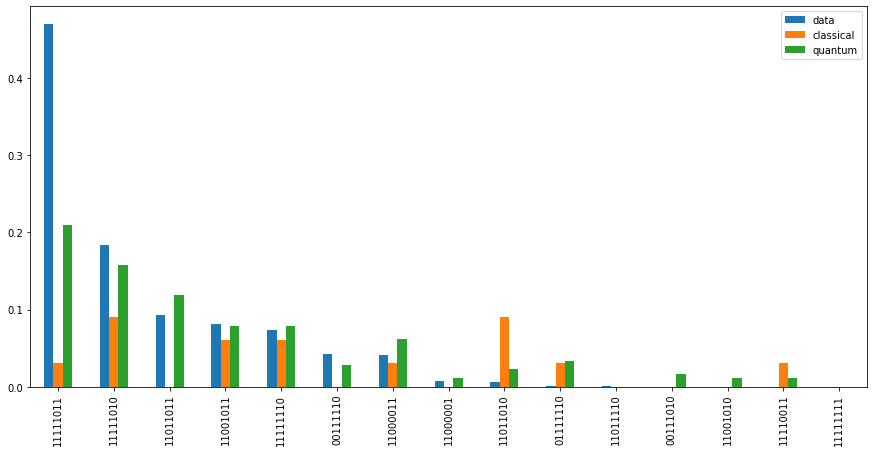

In [ ]:
# classical reconstructed model
cl_mcmc_chain_after_train=classical_mcmc(n_hops=1000,model=training_classical.model, temperature=1,verbose=False)
cl_reconstructed_distn=cl_mcmc_chain_after_train.get_accepted_dict(normalize=True)
#print(cl_reconstructed_distn)
# quantum reconstructed model
q_mcmc_chain_after_train=quantum_enhanced_mcmc(n_hops=1000, model=training_quantum.model,temperature=1,verbose=False)
q_reconstructed_distn=q_mcmc_chain_after_train.get_accepted_dict(normalize=True)
#print(q_reconstructed_distn)

plot_multiple_bargraphs([esm.boltzmann_pd, cl_reconstructed_distn, q_reconstructed_distn],
 ['data','classical', 'quantum'], list_normalise=[False,False,False], plot_first_few= 15)

In [24]:
#plot_multiple_bargraphs([esm.boltzmann_pd, classical_reconstructed_model_esm.boltzmann_pd, quantum_reconstructed_model_esm.boltzmann_pd], ['data','classical', 'quantum'], list_normalise=[False,False,False], plot_first_few= 15)

     MODEL : param_model |  beta : 1.001
Num Most Probable States : 9
Entropy : 2.690821820517544
---------------------------------------------


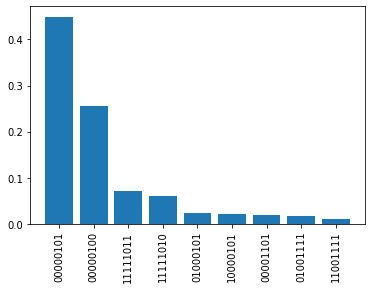

In [ ]:
quantum_reconstructed_model_esm.sampling_summary()